# COVID-19 data exploration and monitoring
With credits to Saeed Amen at Cuemacro (www.cuemacro.com)

With inspiration from Saeed, this notebook intends to explore and visualise the trends of case growth in COVID-19 cases. In particular, I hope to understand more about the density of the infections relative to the population of a particular area.

Currently, the sources for this notebook come from the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE) repository at https://github.com/CSSEGISandData/COVID-19, the source for the data in [another dashboard](https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6).

This repository contains data in multiple forms. As of the time of writing, there are WHO situation reports as well as data from the CSSE COVID-19 dataset. In each of these datasets, there are daily snapshot reports, as well as the time series of each of the datasets. Lastly, there is a directory containing archived data. The CSSE COVID-19 dataset also includes a look-up table for ISO FIPS UID.

In [1]:
REPO_PATH = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
CSSE_DATA_PATH = REPO_PATH + "csse_covid_19_data/"
TIME_SERIES_PATH = CSSE_DATA_PATH + "csse_covid_19_time_series/"

In [2]:
CSV_URL = {}
CSV_URL['CONFIRMED'] = "time_series_covid19_confirmed_global.csv"
CSV_URL['DEATHS'] = "time_series_covid19_deaths_global.csv"
CSV_URL['RECOVERED'] = "time_series_covid19_recovered_global.csv"
CSV_URL['US_CONFIRMED'] = "time_series_covid19_confirmed_US.csv"
CSV_URL['US_DEATHS'] = "time_series_covid19_deaths_US.csv"

In [3]:
# download OECD information
OECD_CSV = "https://stats.oecd.org/sdmx-json/data/DP_LIVE/.POP.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en"

# World Bank population data
WORLDBANK_POP_ZIP = "http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv"

In [4]:
import numpy as np
import pandas as pd
import zipfile as zf
import datetime as dt
import requests
import io

print(f"Numpy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
#print(f"Zipfile version: {zf.__version__}")

%matplotlib inline

Numpy version: 1.18.1
Pandas version: 1.0.3


## Confirmed cases

Research questions to be addressed:
1. Has the pace of infections slowed in the US and other (selected) countries?
2. Is there a "natural" proportion of the population which will be infected before it tails off?
3. How can I identify "regimes" of infection transmission?

In [5]:
df_us_confirmed = (pd.read_csv(TIME_SERIES_PATH + CSV_URL['US_CONFIRMED'])
                   .rename(columns={'Long_': 'Long',
                                    'Country_Region': 'Country/Region',
                                    'Province_State': 'Province/State'
                                   })
                  )
df_confirmed = pd.read_csv(TIME_SERIES_PATH + CSV_URL['CONFIRMED'])

In [6]:
set(df_us_confirmed.columns) - set(df_confirmed.columns)

{'Admin2', 'Combined_Key', 'FIPS', 'UID', 'code3', 'iso2', 'iso3'}

In [7]:
set(df_confirmed.columns) - set(df_us_confirmed.columns)

set()

In [8]:
def _process_columns(col_name):
        try: 
            return dt.datetime.strptime(col_name, '%m/%d/%y').date()
        except ValueError:
            return col_name

In [9]:
df_by_country = (pd.pivot_table(df_confirmed.drop(columns=['Lat', 'Long', 'Province/State']),
                                index=['Country/Region'],
                                aggfunc=np.sum
                               )
                 .rename(columns=_process_columns)
                 .transpose()
                 .sort_index()
                )

## Cases globally

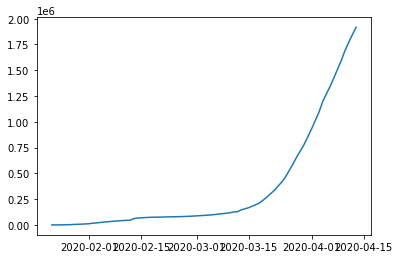

In [10]:
df_by_country.sum(axis=1).plot()

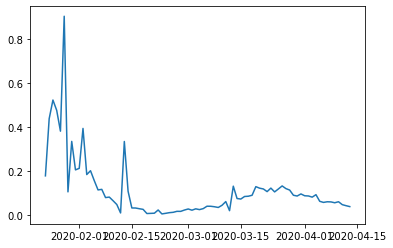

In [11]:
df_by_country.sum(axis=1).pct_change().plot()

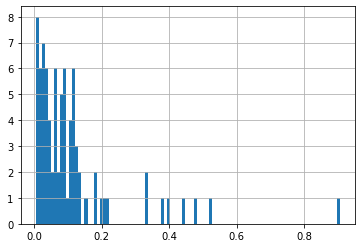

In [13]:
df_by_country.sum(axis=1).pct_change().hist(bins=100)

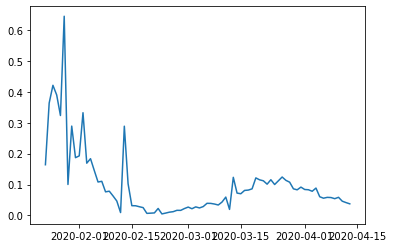

In [14]:
np.log(df_by_country.sum(axis=1)).diff().plot()

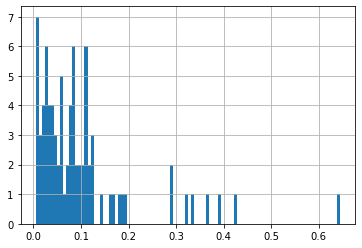

In [15]:
np.log(df_by_country.sum(axis=1)).diff().hist(bins=100)

In [ ]:
def process_JHU():
    
    dfs = {}
    
    # First, retrieve data
    for x in ['confirmed','deaths','recovered']:
        dfs[x + '_RAW'] = (pd.read_csv(TIME_SERIES_PATH + CSV_URL[upper(x)])
                           .rename(columns=_process_columns)
                          )
    
    for x in ['confirmed','deaths']:
        dfs[x + '_US_RAW'] = (pd.read_csv(TIME_SERIES_PATH + CSV_URL['US_' + upper(x)])
                              .rename(columns={'Long_': 'Long',
                                               'Country_Region': 'Country/Region',
                                               'Province_State': 'Province/State'
                                              })
                              .rename(columns=_process_columns)
                             )
        dfs[x + '_GLOBAL'] = _concatenate_US() # concatenate both US and global data
        dfs[x + '_COUNTRY'] = _country_level(dfs[x + '_GLOBAL']) # Generate country-level data
    
    def _country_level(df):
        '''Generate country-level dataframe of numbers from concatenated dataframes.
        '''
        temp_df = df.drop(['Lat', 'Long', 'Province/State'])
        temp_df = pd.pivot_table(temp_df,
                                 index=['Country/Region'],
                                 aggfunc=np.sum
                                )
        return temp_df
    
    def _concatenate_US(global_df, us_df):
        '''Concatenate both dataframes to return country-level information.
        Discards data more granular than the province/state level.
        '''
        temp_df = us_df.copy()
        excess_cols = set(us_df.columns) - set(global_df.columns)
        temp_df = temp_df.drop(excess_cols)
        return temp_df
    
    def _process_columns(col_name):
        try: 
            return dt.datetime.strptime(col_name, '%m/%d/%y').date()
        except ValueError:
            return col_name

In [ ]:
[_process_columns(x) for x in df_confirmed.columns[4:]]

## Population information

In [ ]:
worldbank_pop_request = requests.get(WORLDBANK_POP_ZIP)
with zf.ZipFile(io.BytesIO(worldbank_pop_request.content), 'r') as wb_pop_zip:
    wb_pop_zip.extractall('tmp')

In [ ]:
# to replace if possible
POPULATION_CSV = "API_SP.POP.TOTL_DS2_en_csv_v2_821007.csv"
COUNTRY_METADATA_CSV = "Metadata_Country_API_SP.POP.TOTL_DS2_en_csv_v2_821007.csv"

In [ ]:
df_worldbank_pop = pd.read_csv("tmp/" + POPULATION_CSV, skiprows=2)
df_country_metadata = pd.read_csv("tmp/" + COUNTRY_METADATA_CSV)

In [ ]:
df_worldbank_pop